In [1]:
#########################################################
####
#### Tutorial: RNA Design with Infrared (for Developers)
####
#########################################################

###############################################
## Start with simple sampling of RNA sequences

# -- _the_ main module of Infrared
import infrared as ir

In [2]:
# -- specify a constraint network and it's tree decomp

# our first CN is _very_ simple: 20 variables (=sequence positions), no dependencies\
model = ir.Model()
model.add_variables(20,4)
cn = ir.ConstraintNetwork(model)
# produce cluster tree for the CN, using default tree decomposition
ct = ir.ClusterTree(cn)

tree width = 0
bags = [[18], [2], [8], [12], [3], [15], [1], [5], [4], [19], [16], [0], [6], [17], [13], [14], [10], [7], [9], [11]]
edges = [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19)]


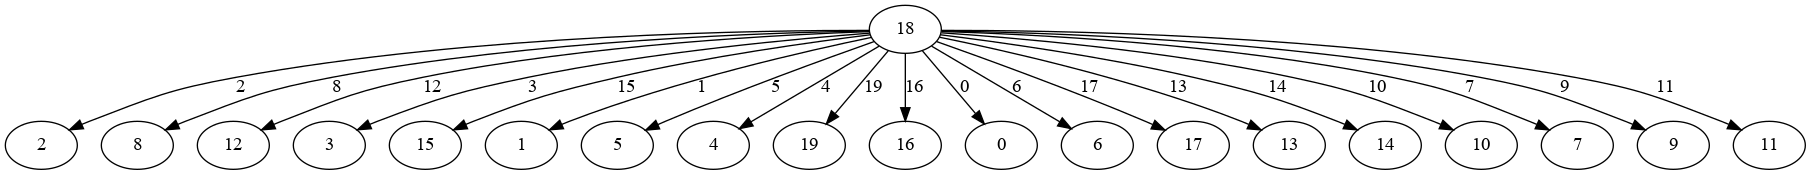

In [3]:
def show_td_info(ct,width):
    td = ct.get_td()
    print("tree width =", td.treewidth())
    print("bags =", td.get_bags())
    print("edges =", td.get_edges())
    
    tmpfile="tmp_out"
    td.writeTD(open(tmpfile+".dot","w"))
    import treedecomp
    treedecomp.dotfile_to_png(tmpfile+".dot")
    from IPython.display import Image
    return Image(filename=(tmpfile+".png"),width=width)
    
show_td_info(ct,500)

In [4]:
# -- evaluate the cluster tree
#   -- in this simple case, this will count the structures
count = ct.evaluate()
print("# =",int(count))
# btw, of course, 'count' is the number of all possible seqs 4**20

# = 1099511627776


In [5]:
# -- generate 10 samples
samples = [ct.sample().values() for i in range(10)]

In [6]:
samples

[[2, 0, 0, 0, 0, 3, 0, 2, 3, 1, 3, 2, 0, 2, 3, 1, 0, 2, 1, 0],
 [3, 1, 3, 3, 1, 3, 1, 1, 0, 2, 2, 3, 3, 1, 2, 1, 2, 3, 2, 3],
 [0, 1, 2, 1, 3, 3, 1, 2, 2, 0, 3, 0, 3, 0, 1, 2, 0, 0, 2, 3],
 [1, 3, 2, 0, 1, 3, 2, 3, 1, 1, 3, 0, 3, 1, 2, 1, 2, 2, 2, 0],
 [3, 0, 1, 2, 3, 3, 2, 3, 2, 2, 1, 2, 1, 1, 3, 3, 1, 3, 3, 0],
 [3, 3, 1, 2, 1, 3, 0, 0, 2, 1, 0, 1, 1, 2, 1, 3, 0, 1, 3, 0],
 [2, 0, 3, 3, 0, 2, 0, 0, 2, 2, 0, 0, 2, 0, 2, 0, 0, 3, 1, 3],
 [3, 3, 0, 3, 0, 0, 1, 0, 3, 0, 2, 3, 0, 0, 0, 0, 2, 0, 2, 3],
 [3, 2, 3, 2, 2, 1, 3, 3, 1, 0, 2, 0, 3, 0, 0, 0, 1, 1, 3, 2],
 [3, 2, 0, 0, 3, 3, 3, 2, 3, 2, 0, 3, 3, 3, 2, 1, 3, 3, 2, 2]]

In [7]:
# -- and show them (pretty)
from infrared import rna
[rna.values_to_sequence(s) for s in samples]

['GAAAAUAGUCUGAGUCAGCA',
 'UCUUCUCCAGGUUCGCGUGU',
 'ACGCUUCGGAUAUACGAAGU',
 'CUGACUGUCCUAUCGCGGGA',
 'UACGUUGUGGCGCCUUCUUA',
 'UUCGCUAAGCACCGCUACUA',
 'GAUUAGAAGGAAGAGAAUCU',
 'UUAUAACAUAGUAAAAGAGU',
 'UGUGGCUUCAGAUAAACCUG',
 'UGAAUUUGUGAUUUGCUUGG']

In [8]:
##################################################
## add constraints from an RNA secondary structure
structure = "((((...))))(((...)))"
bps = rna.parseRNAStructureBps(structure)

In [9]:
bps

[(0, 10), (1, 9), (2, 8), (3, 7), (11, 19), (12, 18), (13, 17)]

In [10]:
complementary_nucleotides = ["AU","CG","GC","GU","UA","UG"]
# -- define complementarity constraints
ir.def_constraint_class( 
    'ComplConstraint',
    lambda i,j: [i,j],
    lambda x,y: rna.values_to_sequence([x,y]) 
                  in complementary_nucleotides
)    
    
## btw, there is already a pre-defined constraint rna.ComplConstraint,
## which we could have used as well

cons = [ ComplConstraint( i , j ) for (i,j) in bps ]
deps = [ x.vars() for x in cons ]

cons, deps

([<infrared.infrared.ComplConstraint at 0x7f2f910380e0>,
 [[0, 10], [1, 9], [2, 8], [3, 7], [11, 19], [12, 18], [13, 17]])

tree width = 1
bags = [[17, 13], [12], [12, 18], [0], [0, 10], [7], [7, 3], [19], [19, 11], [8], [2, 8], [9], [1, 9], [16], [5], [15], [6], [14], [4]]
edges = [(0, 1), (0, 3), (0, 5), (0, 7), (0, 9), (0, 11), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (1, 2), (3, 4), (5, 6), (7, 8), (9, 10), (11, 12)]


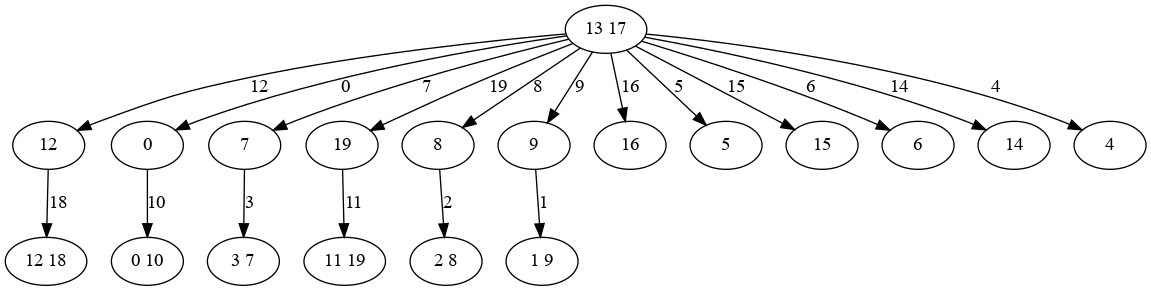

In [11]:
# -- reinitialize constraint network, rebuild tree decomp and cluster tree
#complementary_nucleotides = ["AU"]

seqlen = len(structure) # --> number of positions / variables in the CN
model = ir.Model()
model.add_variables(seqlen,4)
model.add_constraints(cons)
cn = ir.ConstraintNetwork(model)
ct = ir.ClusterTree(cn)

show_td_info(ct,500)

In [12]:
# generate samples (with complementarity constraints)
def spit_them_samples_out(ct,num):
    samples = [ ct.sample().values() for i in range(num) ]
    return [ rna.values_to_sequence(s) for s in samples ]

count = ct.evaluate()
print("# =",int(count))
# btw, count == 6**7 * 4**6, by simple combinatorics

print("  "+structure)
spit_them_samples_out(ct,10)

# = 1146617856
  ((((...))))(((...)))


['GGCAACAUGCUUAGGGCUUG',
 'UUACUCCGUGAAGGCUAUCU',
 'CUGGGAGUCGGGAGGCGCUC',
 'UCAAGGAUUGAGCUACGGGC',
 'UGGCUGGGUUGGUUUACGAC',
 'UCGCACUGCGGACGCCUUGU',
 'CUAUAUCGUGGCAGACUCUG',
 'GCUGCCCUGGCCGGCAUUCG',
 'AUUACGCUAGUUUUAGUAAA',
 'GUGUUUAACAUAUGGCACAU']

In [13]:
##########################
## Control the GC content

# -- define function for GC Control
ir.def_function_class(
    'GCControl',
    lambda i: [i],
    lambda x: rna.value_to_nucleotide( x ) in "GC"
)

## btw, there is predefined rna.GCControl

In [14]:
## -- setup functions
gc_weight = 1 ## <- try different weights: 0.1, 10, ...

gc_funs = [ GCControl( i )
              for i in range( seqlen ) ]

model.add_functions(gc_funs, 'gc')

# -- reinitialize constraint network, rebuild tree decomp and cluster tree
cn = ir.ConstraintNetwork( model )
ct = ir.ClusterTree( cn )

spit_them_samples_out( ct, 10 )

['CCCGGCGCGGGCCUCGGGGG',
 'UCCCCCGGGGGGGCUCCGCC',
 'UCGGGCGCCGAGGGCCGCCC',
 'CGGCGGGGCCGGCGCGUCGU',
 'ACUCAGGGGGUAGGGCACCU',
 'UCGCUGCGUGGGGUGGCAUC',
 'UGGGGGGCCCGCCUGGUGGG',
 'CCCGGCUCGGGGCGGGGCGC',
 'CGUGACCCACGGCGCGGCGC',
 'GCCCGGCGGGUGGGUCGCUU']

In [15]:
##########################
## Control the BP energy

rna.set_bpenergy_table() # set bp energies to magic numbers

bpe_funs = [ rna.BPEnergy( i, j, False ) for (i,j) in bps ] 

model.add_functions(bpe_funs, 'bpenergy')

model.set_feature_weight(0, 'bpenergy')

cn = ir.ConstraintNetwork(model)

ct = ir.ClusterTree(cn)


print("  "+structure)
spit_them_samples_out(ct, 10)

  ((((...))))(((...)))


['CUCUCGUGGGGCGCCUCGUG',
 'ACGGGACCCGUCCGGUGCGG',
 'GAGUUCGACUCGGGUGUCCC',
 'CCGGGUUCCGGACCGAUGGU',
 'GGGUGCAGCCCUGCAUGGCG',
 'GUCGGCCUGGCGUCGGAGGU',
 'CGGUACAAUUGGCCCGCGGC',
 'GGGUGCGGCCCCCGGUGCGG',
 'CGCGCCCCGCGAGUGGCGCU',
 'GGGAGGGUCCCCCAUGUUGG']

In [16]:
### as example of additional hard constraints: avoid GG dinucleotides

ir.def_constraint_class('AvoidGGConstraint',
                         lambda i: [i, i+1],
                         lambda x,y: rna.values_to_sequence([x,y]) != "GG")

gg_cons = [ AvoidGGConstraint( i ) for i in range(seqlen-1) ]

In [17]:
model.add_constraints(gg_cons)

cn = ir.ConstraintNetwork(model)

ct = ir.ClusterTree(cn)

print("  "+structure)
spit_them_samples_out(ct, 10)

  ((((...))))(((...)))


['UACGCGAUGUGCUCUCAGAG',
 'GUGAGUAUCGCCGUAGCGUG',
 'GAGCCGAGCUCCGCCCCGCG',
 'GCGCGACGCGCCGUGCCGCG',
 'GUGCCGCGCACAAGUGCUUU',
 'UGUGCCGCGUGCGCGUCGCG',
 'GUGUCCAACAUGCGCGCCGC',
 'GCGCUGCGUGUGACGCAGUU',
 'UUCGUCACGAAGUACGCUGC',
 'GCGCCCCGUGCCGCUGAGUG']

In [18]:
# -- from this, construct the sampler

model =  ir.Model()
model.add_variables(seqlen, 4)
model.add_constraints(cons)
model.add_functions(bpe_funs, 'bpenergy')
model.add_functions(gc_funs, 'gc')

sampler = ir.MultiDimensionalBoltzmannSampler(model)

sampler.set_target( -12, 1, 'bpenergy' )
sampler.set_target( 10, 2, 'gc' )

def s2s(sample):
    return rna.values_to_sequence(sample.values())


# -- and sample away

for i in range(10):
    sample = sampler.targeted_sample()
    print("{} {:.2f} {:.2f}".format(s2s(sample), 
                                    model.eval_feature(sample,'bpenergy'),
                                    model.eval_feature(sample,'gc')))

CGGCUUAGUCGCACUGAGUG -11.92 12.00
CCCUACAAGGGGCACUAUGC -11.56 12.00
CUGGUGACCGGGGGUAAUCU -11.06 12.00
CACGCCACGUGGCAUAUUGC -11.56 12.00
GCUCUGAGAGCGGAAACUCC -11.56 12.00
GCUGUGACAGCAGGAGACCU -11.56 12.00
CCGCUAAGUGGCUCUUUGAG -11.92 11.00
CCCAUUUUGGGGCUACUAGC -11.56 11.00
CCCAAAUUGGGCGGUCAUCG -11.92 12.00
GGCAUAAUGCCCACGAGGUG -11.56 12.00


In [19]:
## similar but with control of Turner energy
import RNA

model.add_feature( 'Energy', # feature name
                   'bpenergy', # controlled group(s)
                   #
                   # function to evaluate the feature for a sample;
                   # NOTE how we have to bind i
                   lambda sample, structure=structure:
                      RNA.energy_of_struct( rna.values_to_sequence( sample.values() ),
                                            structure )
                 )

sampler = ir.MultiDimensionalBoltzmannSampler(model)

#sampler.set_target( -11, 1, 'bpenergy' )
sampler.set_target( -5, 1, 'Energy' )
#sampler.set_target( 10, 2, 'gc' )

# -- and sample away

for i in range(10):
    sample = sampler.targeted_sample()
    print("{} {:5.2f} {:5.2f} {:5.2f}".format(s2s(sample), 
                                    model.eval_feature(sample,'bpenergy'),
                                    model.eval_feature(sample,'Energy'),
                                    model.eval_feature(sample,'gc')))

GGCUGAAAGCCGACAUUGUC -11.56 -4.10 11.00
GGCUAUUAGCCGUCCCAGAC -11.56 -4.10 12.00
GUCCUAUGGACAGGUUUCCU -11.56 -4.00 10.00
GAGGUCACCUCGCUUAAAGC -11.56 -4.00 11.00
GAGUAUAGCUCGGCCUAGCC -11.92 -4.40 12.00
GGCCUAAGGCCUGAUUGUCA -11.56 -4.00 11.00
GCGUUUAGCGCACCUGAGGU -11.92 -4.00 12.00
GAGUAGUACUCGGCAAGGCC -11.56 -4.10 12.00
GGGUAAUGCCCACCAGAGGU -11.92 -4.80 12.00
GGCCCAUGGCCGAUUAUGUC -11.92 -4.50 12.00


# Multiple target design a la RNARedPrint in new syntax

In [20]:
import infrared as ir
from infrared import rna
import RNA

##################################################
## our target RNA secondary structure
#             01234567890123456789
structures = list()
structures.append( "((((...)))).(((...)))" )
structures.append( "((((((......)))...)))" )
#structures.append( "......(((...)))......" )

seqlen = len(structures[0])

######
# construct the constraint model
model = ir.Model()

# one variable X_i per position i;
# the value of X_i encodes the nucleotide at position i   
model.add_variables( seqlen, 4 )


for i,structure in enumerate(structures):
    bps = rna.parseRNAStructureBps(structure)

    model.add_constraints( rna.ComplConstraint( i = i, j = j ) for ( i, j ) in bps )
    
    model.add_functions( [ rna.BPEnergy( i = i, j = j, is_terminal = False ) 
                           for ( i, j ) in bps ], group = f'bpenergy{i}' )
    
    model.add_feature( f'E{i}', # feature name
                       f'bpenergy{i}', # controlled group(s)
                       #
                       # function to evaluate the feature for a sample;
                       # NOTE how we have to bind i
                       lambda sample, i=i: RNA.energy_of_struct( rna.values_to_sequence( sample.values() ),
                                              structures[i] )
                     )

model.add_functions( [ rna.GCControl( i = i ) for i in range(seqlen) ], group = 'gc' )

# the model generates automatic features 'bpenergyI', 'gc' from the function groups;
# as well as total feature combining all function groups;
# however, we want to diretly control Turner energy (instead of base pair energy).
# For this purpose, add additional features 'EI'


def print_sample(sample):    
    seq = rna.values_to_sequence( sample.values() )
    
    print("{} GC={:.2f}".format( seq,
                              model.eval_feature(sample, 'gc')*100/seqlen ),end=""
         )
    for i,s in enumerate(structures):
        print(f" E{i}={model.eval_feature(sample, f'E{i}'):.2f}",end="")
    print()
    


print("###########################################")    
## Sampling at specific weights

sampler = ir.BoltzmannSampler( model )

print( "Tree width:", sampler.treewidth() )

sampler.plot_td("treedecomp.pdf")

######
# set targets

model.set_feature_weight( -5, 'E0' )
model.set_feature_weight( -2, 'gc' )

######
# and draw samples
for i in range(10):
    sample = sampler.sample()
    print_sample(sample)
    
    
print("###########################################")    
## MDBS

model.set_feature_weight( 0, 'E0' )
model.set_feature_weight( 0, 'E1' )
#model.set_feature_weight( 0, 'E2' )
model.set_feature_weight( 0, 'gc' )

######
# create sampler
sampler = ir.MultiDimensionalBoltzmannSampler( model )

######
# set targets

# control number of gc's; we target 70% +/- 15% GC-content
sampler.set_target( 0.85 * seqlen, 0.02 * seqlen, 'gc' )

# control Turner energy, target -2 +/- 1 kcal/mol
sampler.set_target( -2, 0.2, 'E0' )

# control Turner energy, target -2 +/- 1 kcal/mol
sampler.set_target( -3, 0.2, 'E1' )

# control Turner energy, target -2 +/- 1 kcal/mol
#sampler.set_target( -1.5, 0.2, 'E2' )

######
# and draw samples
for i in range(10):
    sample = sampler.targeted_sample()
    print_sample(sample)

###########################################
Tree width: 1
GGCGUUCCGCCUGGCAAUGCC GC=71.43 E0=-6.20 E1=-1.10
GGCGUUACGCCUGGCAUAGCC GC=66.67 E0=-4.70 E1=-1.40
GGCGUUGCGCCAGGCACUGCC GC=76.19 E0=-6.90 E1=-2.00
GGCGUUACGCCAGGUUAUGCC GC=61.90 E0=-4.00 E1=2.70
GGCGUUACGCCUAGCCUUGCU GC=61.90 E0=-3.20 E1=0.20
GGGCUUAGCCCAGGGUGACCC GC=71.43 E0=-7.70 E1=-1.10
GGCGUUUCGCCUGGCUUUGCC GC=66.67 E0=-6.20 E1=-2.00
GCCGGUUCGGCUGCCUUAGGC GC=71.43 E0=-6.20 E1=-4.80
GGGCUUGGCCCUGGGAAUCCC GC=71.43 E0=-7.00 E1=-0.90
GGCGUCACGCCUGGUAUAGCC GC=66.67 E0=-4.80 E1=0.70
###########################################
GGGCCCCGCCUUGGGCGGUCC GC=85.71 E0=-1.90 E1=-3.10
CGUGCGGCGCGUCGCCAGGCG GC=85.71 E0=-2.00 E1=-3.10
CGUGCGGCGCGUCGCACCGCG GC=85.71 E0=-2.00 E1=-3.10
GCGCGCUGUGCCGCGCGGCGU GC=85.71 E0=-2.00 E1=-3.00
GUCGGCCUGGCUGCCGCCGGC GC=85.71 E0=-2.00 E1=-2.90
CGUGCGACGCGCCGCGCUGCG GC=85.71 E0=-2.00 E1=-3.10
GGGCCCCGCCUUGGGGGGUCC GC=85.71 E0=-1.90 E1=-3.10
CGGUCGGGCUGACGGGCGCCG GC=85.71 E0=-2.00 E1=-3.00
GGUGUCGCGCUGGGCCCCG